# Analisis de datos

En este notebook descargamos los ejemplos de musica de hugging faces y los procesamos para que puedan ser usados por cualquier modelo generativo. Luego se guarda el dataset limpio en formato json.

# Prerequisitos

Es necesario descargar los archivos parquet la pagina de huggingface del [dataset](https://huggingface.co/datasets/lewtun/music_genres/tree/main/data) y ponerlos en la carpeta data en la raiz. Al momento de probar con load_data de huggingfaces, se obtuvo el error **HfHubHTTPError: 500 Server Error: Internal Server Error for url:**, por lo cual la descarga se tuvo que hacer manualmente.

# Librerias

In [1]:
import os
import io
import gc
import json
import random

import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.fft import fft
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
from joblib import Parallel, delayed

# Constantes

In [2]:
# Carpeta con archivos parquet
RAW_DATASET_FOLDER = "../data"
# Carpeta para guardar ejemplos estandarizados y limpios
CLEANED_DATASET_FOLDER = "../cleaned_data"

In [3]:
ANALYSIS_DATAFRAME = "analysis.parquet"

In [4]:
RANDOM_SEED = 42

# Funciones

## Utils

In [5]:
def list_parquet_files() -> list[str]:
    """Lista la ruta completa de los archivos parquet del dataset"""
    return [os.path.join(RAW_DATASET_FOLDER, file) for file in os.listdir(RAW_DATASET_FOLDER)]

In [6]:
def decode_audio(binary_data):
    # Convert bytes to file-like object
    audio_file = io.BytesIO(binary_data)
    
    # Load audio file using librosa
    y, sr = librosa.load(audio_file, sr=None)  # `sr=None` to keep the original sampling rate
    
    return y.tolist(), sr

## Funciones de analisis

In [7]:
def analyze_example(example: dict[any]) -> None:
    # Audio bytes to amplitude array
    time_series, sampling_rate = decode_audio(
        example["audio"]["bytes"]
    )

    # Fourier transform to find strongest frequency
    frequency_domain = fft(time_series)
    strongest_freq = np.argmax(frequency_domain).tolist()
    
    return {
        "song_id": example["song_id"], 
        "genre": example["genre"],
        "sampling_rate": sampling_rate,        
        "len_time_series": len(time_series),
        "strongest_freq": strongest_freq
    }

In [8]:
def analyze_parquet(parquet_path: str) -> None:
    df = pd.read_parquet(parquet_path, engine='pyarrow')
    df.drop(columns=['genre_id'], inplace=True)

    parquet_analysis = Parallel(n_jobs=-1, verbose=10)(
        delayed(analyze_example)(
            example
        )
        for example in df.to_dict(orient="records")
    )
    return pd.DataFrame(parquet_analysis)

In [9]:
def analyze_dataset():
    return pd.concat([
        analyze_parquet(parquet_file)
        for parquet_file in tqdm(list_parquet_files())
    ])

## Funciones de extraccion

In [10]:
def write_example(example: dict, time_series_size):
    song_id = example["song_id"]
    time_series, _ = decode_audio(
        example["audio"]["bytes"]
    )
    example["time_series"] = time_series[:time_series_size]
    example.pop("audio", None)
    saving_file = f"{CLEANED_DATASET_FOLDER}/{song_id}.npy"
    np.save(saving_file, example)

In [11]:
def parquet_to_examples(parquet_path: str, selected_ids: list, time_series_size: int):
    if not os.path.exists(CLEANED_DATASET_FOLDER):
        os.mkdir(CLEANED_DATASET_FOLDER)
    df = pd.read_parquet(parquet_path, engine='pyarrow')
    df_selected = df[df["song_id"].isin(selected_ids)]
    _ = Parallel(n_jobs=-1, verbose=10)(
        delayed(write_example)(
            example, time_series_size
        )
        for example in df_selected.to_dict(orient="records")
    )

In [12]:
def generate_dataset(selected_ids: list, time_series_size: int):
    for parquet_file in tqdm(list_parquet_files()):
        parquet_to_examples(parquet_file, selected_ids, time_series_size)

# Analisis de datos

## Carga estadisticos de dataset

Se recorre cada archivo parquet para extraer estadisticas de las canciones.

In [13]:
if not os.path.exists(ANALYSIS_DATAFRAME):
    df_analysis = analyze_dataset()
    df_analysis.to_parquet(ANALYSIS_DATAFRAME)
else:
    df_analysis = pd.read_parquet(ANALYSIS_DATAFRAME)

## Analisis preliminar

Los estadisticos que se extraen estan por cancion, teniendo el genero y sampling rate para agrupar las estadisticas. Estas ultimas corresponden a la longitud de la serie de tiempo y el pico de frecuencia mas comun, para identificar patrones comunes en cada grupo.

In [14]:
df_analysis.shape

(24985, 5)

In [15]:
df_analysis.head(5)

,song_id,genre,sampling_rate,len_time_series,strongest_freq
0,6231,Unknown,44100,1323119,564
1,6233,Unknown,44100,1321967,1471
2,6241,Unknown,48000,1439471,1437280
3,6243,Unknown,44100,1321967,1318243
4,6247,Unknown,44100,1321967,1319019


En el dataset original se tienen 24985 ejemplos, de los cuales extrajimos las siguientes caracteristicas:
- id de la cancion
- genero de la cancion
- tasa de muestreo de la cancion
- longitud de la serie de tiempo
- frecuencia mas potente (estacionalidad) con la transformada rapida de fourier

In [16]:
df_analysis.describe(include=np.number)

,song_id,sampling_rate,len_time_series,strongest_freq
count,24985.000000,24985.000000,2.498500e+04,2.498500e+04
mean,12497.595357,44228.373024,1.326084e+06,6.599513e+05
std,7216.373368,1219.107886,4.024935e+04,6.576700e+05
min,0.000000,22050.000000,2.251100e+04,0.000000e+00
25%,6249.000000,44100.000000,1.321967e+06,2.967000e+03
50%,12497.000000,44100.000000,1.321967e+06,5.906100e+04
75%,18747.000000,44100.000000,1.323119e+06,1.319389e+06
max,24999.000000,48000.000000,1.439471e+06,1.439456e+06


In [17]:
df_analysis.describe(include="O")

,genre
count,24985
unique,20
top,Unknown
freq,5076


In [18]:
df_analysis["song_id"].nunique() == len(df_analysis)

True

Encontramos que ninguna de las variables tiene valores nulos, y algunas de ellas presentan una alta variabilidad, como los son song_id, un identificador numerico unico, y la estacionalidad, dado que no es un calculo exacto. Por otro lado se tiene que existen 20 generos, de los cuales el mas comun es Unknown.

## Analisis univariado y multivariado

### Frecuencia de generos

<Axes: title={'center': 'Conteo de ejemplos por genero'}, xlabel='genre'>

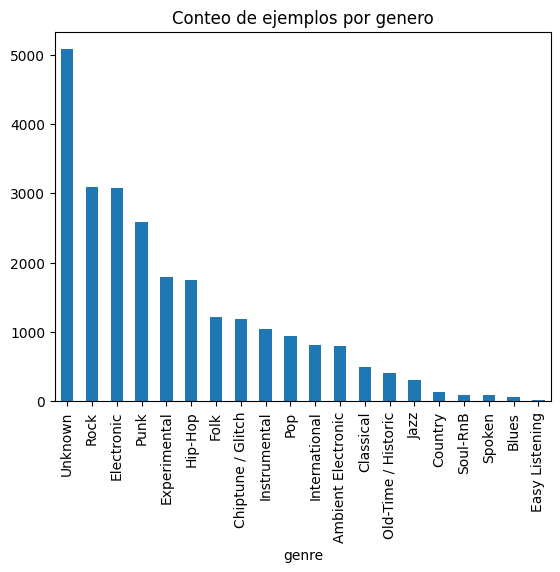

In [19]:
df_genre_count = df_analysis["genre"].value_counts()
df_genre_count.plot(kind="bar", title="Conteo de ejemplos por genero")

<Axes: title={'center': 'Porcentaje de ejemplos por genero'}, xlabel='genre'>

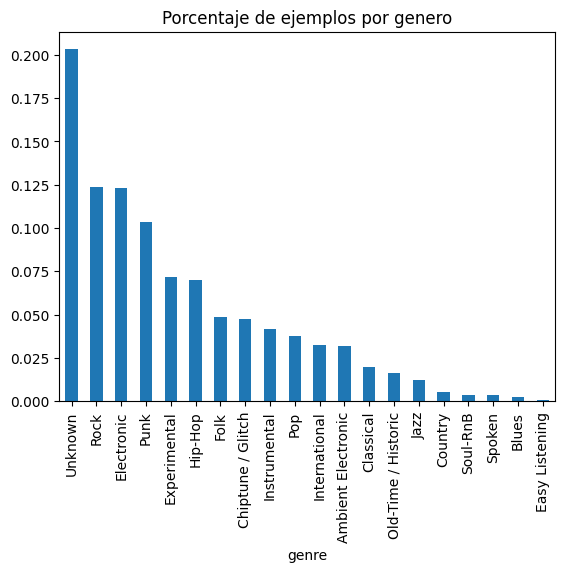

In [20]:
(df_genre_count/len(df_analysis)).plot(kind="bar", title="Porcentaje de ejemplos por genero")

Encontramos que el genero mas comun es Unknown, con 20% de los datos, seguido de rock y electronic para sumar 50% de los datos. Debido a que se utilizan modelos condicionados, se elimina la categoria Unknown, ya que no podemos asegurar que las canciones en este NO se asemejen como pertenecientes a otras distribuciones de otros generos, lo cual puede confundir a los modelos.

In [21]:
df_analysis = df_analysis[df_analysis["genre"] != "Unknown"].copy(deep=True)

<Axes: title={'center': 'Porcentaje de ejemplos por genero'}, xlabel='genre'>

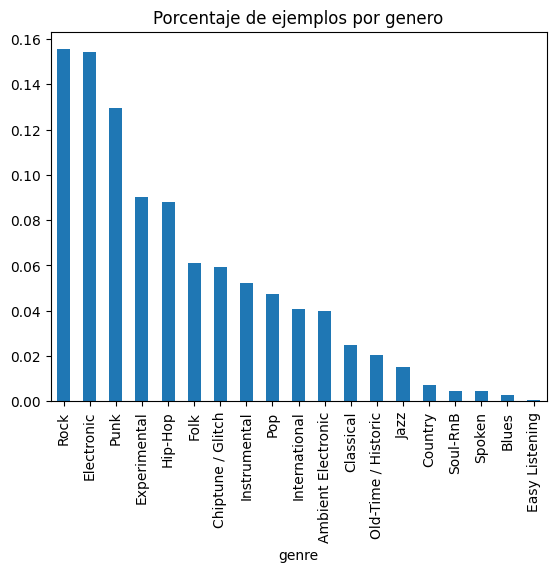

In [22]:
df_genre_count = df_analysis["genre"].value_counts()
(df_genre_count/len(df_analysis)).plot(kind="bar", title="Porcentaje de ejemplos por genero")

In [23]:
df_analysis["genre"].value_counts(normalize=True).cumsum()

genre
Rock                   0.155457
Electronic             0.309709
Punk                   0.439399
Experimental           0.529811
Hip-Hop                0.618062
Folk                   0.679040
Chiptune / Glitch      0.738360
Instrumental           0.790798
Pop                    0.838264
International          0.879150
Ambient Electronic     0.919132
Classical              0.943995
Old-Time / Historic    0.964488
Jazz                   0.979858
Country                0.986991
Soul-RnB               0.991712
Spoken                 0.996434
Blues                  0.999347
Easy Listening         1.000000
Name: proportion, dtype: float64

In [24]:
df_genre_count[df_genre_count > 1000]

genre
Rock                 3095
Electronic           3071
Punk                 2582
Experimental         1800
Hip-Hop              1757
Folk                 1214
Chiptune / Glitch    1181
Instrumental         1044
Name: count, dtype: int64

In [25]:
df_genre_count[df_genre_count > 1000].sum()

np.int64(15744)

Al repetir el conteo sin la categoria Unknown, encontramos que con los generos mas comunes que tienen mas de 1000 canciones cubren el 80% del dataset. Queremos quedarnos con estos generos, ya que nos asegura tener una cantidad de ejemplos aceptable para el aprendizaje de modelo, lo cual nos deja con 15744 canciones. **Notese que esto es una heuristica usada para disminuir el numero de ejemplos maximizando la cantidad de ejemplos por categoria**.

In [26]:
df_analysis = df_analysis[
    df_analysis["genre"].isin(
        df_genre_count[df_genre_count > 1000].index
    )
].copy(deep=True)

In [27]:
len(df_analysis)

15744

### Frecuencia de sampling rate

<Axes: title={'center': 'Porcentaje de ejemplos por sampling rate'}, xlabel='sampling_rate'>

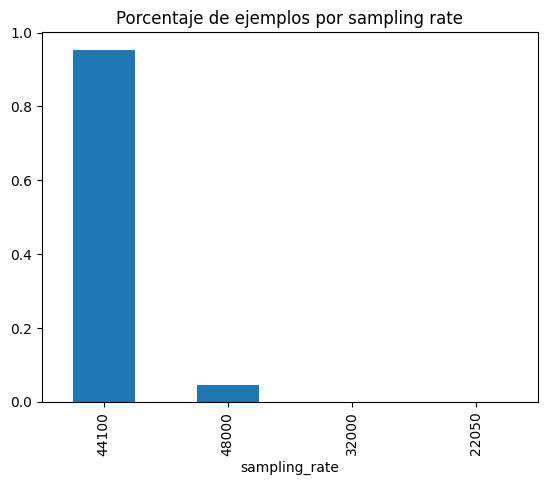

In [28]:
df_rate_count = df_analysis["sampling_rate"].value_counts(normalize=True)
df_rate_count.plot(kind="bar", title="Porcentaje de ejemplos por sampling rate")

In [29]:
df_rate_count

sampling_rate
44100    0.953887
48000    0.045605
32000    0.000445
22050    0.000064
Name: proportion, dtype: float64

Al analizar la tasa de muestreo, encontramos que casi todas las canciones (mas del 95%) estan muestreadas en 44100 hz. Como los modelos se alimentan de series de tiempo regulares, necesitamos que todos los ejemplos tengan la misma tasa de muestreo, asi que nos quedamos con aquellos que tienen la tasa de muestreo de 44100hz.

In [30]:
df_analysis = df_analysis[
    df_analysis["sampling_rate"] == 44100
].copy(deep=True)

Al volver a revisar los generos, encontramos que Instrumental tiene menos de 1000 ejemplos, asi que lo eliminamos.

In [31]:
df_analysis["genre"].value_counts()

genre
Electronic           2993
Rock                 2992
Punk                 2387
Experimental         1735
Hip-Hop              1704
Folk                 1188
Chiptune / Glitch    1131
Instrumental          888
Name: count, dtype: int64

In [32]:
df_analysis = df_analysis[df_analysis["genre"] != "Instrumental"].copy(deep=True)

### Frecuencia de longitud de series de tiempo

<Axes: title={'center': 'Porcentaje de ejemplos por longitud'}, xlabel='len_time_series'>

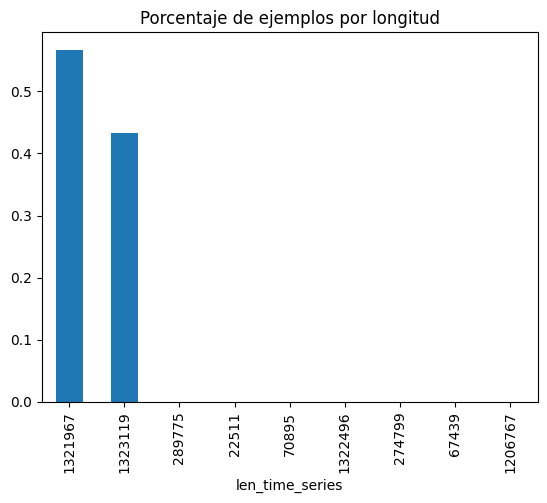

In [33]:
df_len_count = df_analysis["len_time_series"].value_counts(normalize=True)
df_len_count.plot(kind="bar", title="Porcentaje de ejemplos por longitud")

In [34]:
df_len_count.sort_index()

len_time_series
22511      0.000071
67439      0.000071
70895      0.000071
274799     0.000071
289775     0.000071
1206767    0.000071
1321967    0.566950
1322496    0.000071
1323119    0.432555
Name: proportion, dtype: float64

Al observar la longitud de las series de tiempo, encontramos que menos del 1% tiene una longitud menor a 1321967 timesteps, por lo que eliminamos las series que tienen menor longitud que esta. **Para estandarizar las series de tiempo, tambien se hara un clip de longitud hasta este mismo valor**.

In [35]:
MAX_LENGTH = 1321967

In [36]:
df_analysis = df_analysis[
    df_analysis["len_time_series"] >= MAX_LENGTH
].copy(deep=True)

In [37]:
df_analysis["genre"].value_counts()

genre
Electronic           2993
Rock                 2992
Punk                 2386
Experimental         1735
Hip-Hop              1699
Folk                 1188
Chiptune / Glitch    1131
Name: count, dtype: int64

In [38]:
len(df_analysis)

14124

### Distribucion de periodos estacionales mas fuertes

In [39]:
df_analysis["strongest_freq"].nunique()

8305

<Axes: title={'center': 'Distribucion de periodos estacionales'}, ylabel='Frequency'>

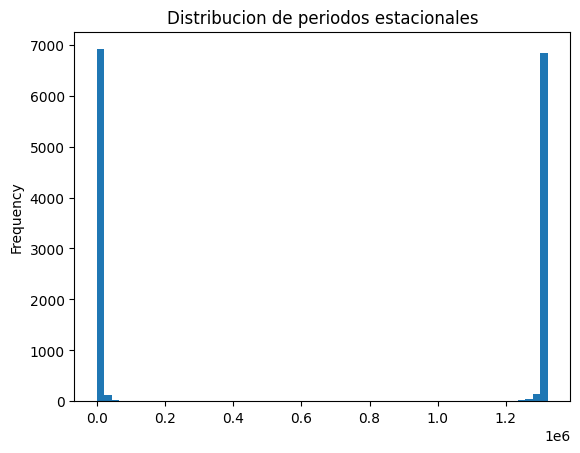

In [40]:
df_freq_count = df_analysis["strongest_freq"].value_counts()
df_analysis["strongest_freq"].plot(kind="hist", title="Distribucion de periodos estacionales", bins=60)

Desafortunadamente, el metodo usado para extraer la estacionalidad mas fuerte de las series de tiempo parece no ser exitoso, ya que encontramos que la estacionalidad detectada esta en valores cercanos a cero, lo cual implica dependencias de corto plazo, y al final de la longitud de la serie, lo cual implica que no hay relaciones como tal. Se tiene la hipotesis de que esto puede darse debido a que el audio procesado se crea como de un solo canal, combinando multiples canales y ondas de sonido correspondientes a diferentes instrumentos y voces, pero perdiendo calidad.

### genre vs strongest_freq

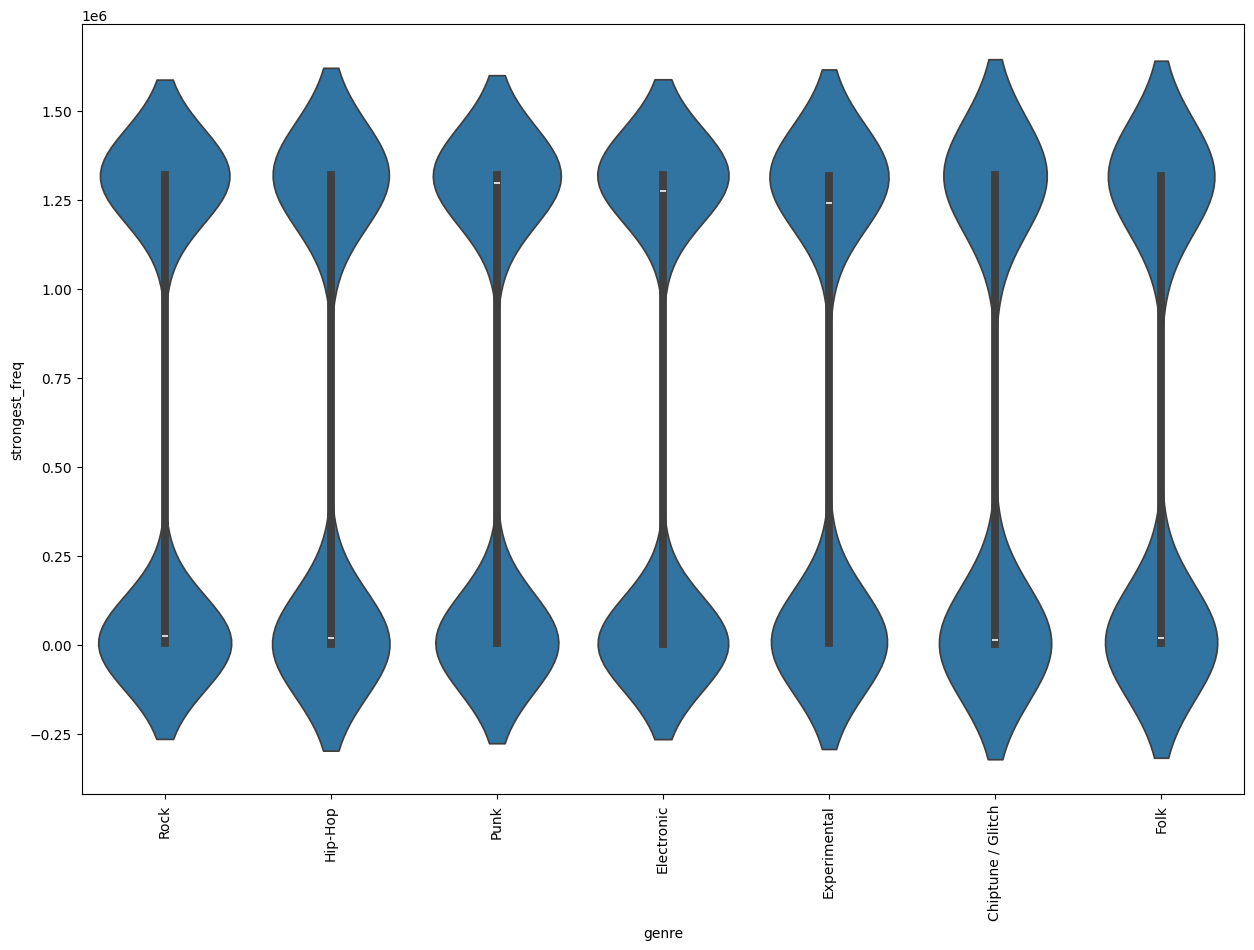

In [41]:
plt.figure(figsize=(15,10))
sns.violinplot(
    df_analysis[df_analysis["sampling_rate"] == 44100],
    y="strongest_freq",
    x="genre",
)
plt.xticks(rotation=90)
plt.show()

Al visualizar las estacionalides por genero, encontramos el mismo patron por grupo que el de la poblacion.

## Resultado del analisis

Luego de analizar las series de tiempo por estadisticos agrupados, nos quedamos con los siguientes 7 generos, cada uno con mas de 1000 ejemplos.

In [42]:
df_analysis["genre"].value_counts()

genre
Electronic           2993
Rock                 2992
Punk                 2386
Experimental         1735
Hip-Hop              1699
Folk                 1188
Chiptune / Glitch    1131
Name: count, dtype: int64

In [43]:
SELECTED_SONGS = df_analysis["song_id"].tolist()
len(SELECTED_SONGS)

14124

In [44]:
MAX_LENGTH

1321967

Todas las 14124 canciones que conservamos estan muestreadas a una tasa de 44100 hz, y tienen un minimo de 1321967 pasos.

## Correciones por capacidades computacionales

Almacenar un ejemplo en formato npy, debido a la alta dimensionalidad de la serie de tiempo, ocupa cerca de 11.4MB. Si tomaramos todos los ejemplos seleccionados, el resultado seria un dataset de 161 GB en disco, lo cual seria imposible de entrenar en el tiempo que tenemos. Por ende, decidimos muestrear 350 ejemplos de cada una de las dos clases mas opuestas. Segun GPT, las clases mas opuestas son Electronic vs. Folk. Estos dos géneros son muy distintos. La música electrónica usa tecnología avanzada para crear sonidos sintéticos, mientras que el folk se basa en instrumentos acústicos y tradiciones culturales. La producción, la estructura y el sonido son casi opuestos.

In [45]:
df_analysis = df_analysis[
    df_analysis["genre"].isin(["Electronic", "Folk"])
]
df_analysis["genre"].value_counts()

genre
Electronic    2993
Folk          1188
Name: count, dtype: int64

In [46]:
electronic_songs = df_analysis[df_analysis["genre"] == "Electronic"].sample(n=350, random_state=RANDOM_SEED)["song_id"].tolist()
folk_songs = df_analysis[df_analysis["genre"] == "Folk"].sample(n=350, random_state=RANDOM_SEED)["song_id"].tolist()
len(electronic_songs), len(folk_songs)

(10, 10)

In [47]:
SELECTED_SONGS = electronic_songs + folk_songs
random.shuffle(SELECTED_SONGS)
len(SELECTED_SONGS)

20

# Generacion de dataset

Partiendo de las conclusiones y ejemplos seleccionados del analisis de datos, procedemos a crear una carpeta de dataset en formato JSON.

In [ ]:
generate_dataset(SELECTED_SONGS, MAX_LENGTH)

In [49]:
!ls -l ../cleaned_data | wc -l

701
